<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Text Analytics - Assignment 2
COMPETITION TASK: 

+ Learn the classification model for training set with 5 categorical data from ['business', 'entertainment', 'politics', 'sport', 'tech'].

+ Apply learned model to get the labels for "testdata.csv"

## Team Members: 
Laura Brierton - 15317451, Clodagh Lalor - 13354426, Jeremy Schiff - student#, Peter Concannon - student#

============================================================================================================================

In [1]:
##jupyter extension to create table of contents
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

# Pre-Processing

## Step 1: Import packages

In [22]:
import pandas as pd
import numpy as np
import nltk, json
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
import nltk
from nltk import ngrams

In [3]:
raw_trainset = pd.read_csv('trainingset.csv',sep='^',header=0)
raw_testdata = pd.read_csv('testdata.csv',sep='^',header=0)
raw_trainset.head()

,content,category
0,French boss to leave EADS The French co-head o...,business
1,"Gamers could drive high-definition TV, films, ...",tech
2,Stalemate in pension strike talks Talks aimed ...,politics
3,Johnny and Denise lose Passport Johnny Vaughan...,entertainment
4,Tautou 'to star in Da Vinci film' French actre...,entertainment


## Step 2: Extract Tokens

In [13]:
## Define the Function to convert raw text to tokens
def convert_tokens(rawtext, verbose):
    # First: Tokenization
    pattern = r'\w+'
    tokenizer = RegexpTokenizer(pattern)
    token_words = tokenizer.tokenize(rawtext)
    if (verbose):
        print('Tokens:' + str(token_words[0:10]))
    
    # Second: Decapitalization 
    decap_token_words = [word.lower() for word in token_words]
    if (verbose):
        print('Decapitalized Tokens:' + str(decap_token_words[0:10]))
    
    # Third: Remove stop words
    json_data=open('stopwords.json', encoding="utf8").read()
    stopwords_json = json.loads(json_data)
    stopwords_json_en = set(stopwords_json['en'])
    stopwords_nltk_en = set(stopwords.words('english'))
    # Combine the stopwords. Its a lot longer so I'm not printing it out...
    stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en)

    ##** Depending on whether we use the second step or not **
    
    rmsw_token_words = ([word for word in token_words if word.lower() not in stoplist_combined])
    ##rmsw_token_words = ([word for word in decap_token_words if word.lower() not in stoplist_combined])
    if (verbose):
        print('Stopwords removed:' + str(rmsw_token_words[0:20]))
    
    ## Fouth: remove CAP words
    rmcap_token_words =[]
    for word in rmsw_token_words:
        if word.isupper():
            rmcap_token_words.append(word.title())
        else:
            rmcap_token_words.append(word)
    if (verbose):
        print('CAPITALIZED removed:' + str(rmcap_token_words[0:20]))
        
     ## Fifth : Remove salutation
    salutation = ['mr','mrs','mss','dr','phd','prof','rev', 'professor']
    rmsalu_token_words = ([word for word in rmcap_token_words if word.lower() not in salutation])
    if (verbose):
        print('Salutation removed:' + str(rmsalu_token_words[0:20]))
        
     ## Sixth: Remove Numbers
    rmnb_token_words = ([word for word in rmsalu_token_words if not word.isdigit()])
    if (verbose):
        print('Number removed: ' + str(rmnb_token_words[0:20]))
        
    ## define transfer tag function:
    def transfer_tag(treebank_tag):
        if treebank_tag.startswith('j' or 'J'):
            return 'a'
        elif treebank_tag.startswith('v' or 'V'):
            return 'v'
        elif treebank_tag.startswith('n' or 'N'):
            return 'n'
        elif treebank_tag.startswith('r' or 'R'):
            return 'r'
        else:
            # As default pos in lemmatization is Noun
            return 'n'
    
    ## Seventh: Lemmatization
    wnl = WordNetLemmatizer()

    lemma_words = []
    for word, tag in nltk.pos_tag(rmnb_token_words):
        firstletter = tag[0].lower() # -> get the first letter of tag and put them decapitalized form
        wtag = transfer_tag(firstletter) # -> extract the word's tag (noun, verb, adverb, adjective)
        if not wtag:
            lemma_words.extend([word])
        else:
            lemma_words.extend([wnl.lemmatize(word, wtag)]) # -> get lemma for word with tag
    if (verbose):
        print('Lemmas : ' + str(lemma_words[0:10]))
        
    
    ## RETURN
    return lemma_words

In [14]:
df_handle = raw_trainset.copy()
[n,d] = df_handle.shape
df_handle['Tokens'] = ['']*n

for index, row in df_handle.iterrows():
    df_handle['Tokens'].iloc[index] = convert_tokens(row['content'],0)
    
df_handle.head(10)

,content,category,Tokens
0,French boss to leave EADS The French co-head o...,business,"[French, bos, leave, Eads, French, head, Europ..."
1,"Gamers could drive high-definition TV, films, ...",tech,"[Gamers, drive, high, definition, Tv, film, ga..."
2,Stalemate in pension strike talks Talks aimed ...,politics,"[Stalemate, pension, strike, talk, Talks, aim,..."
3,Johnny and Denise lose Passport Johnny Vaughan...,entertainment,"[Johnny, Denise, lose, Passport, Johnny, Vaugh..."
4,Tautou 'to star in Da Vinci film' French actre...,entertainment,"[Tautou, star, Da, Vinci, film, French, actres..."
5,Media seek Jackson 'juror' notes Reporters cov...,entertainment,"[Media, seek, Jackson, juror, note, Reporters,..."
6,Horror film heads US box office A low-budget h...,entertainment,"[Horror, film, head, box, office, low, budget,..."
7,Kerr frustrated at victory margin Republic of ...,sport,"[Kerr, frustrate, victory, margin, Republic, I..."
8,US casino 'tricks' face ban in UK Controversia...,politics,"[casino, trick, face, ban, Uk, Controversial, ..."
9,Klinsmann issues Lehmann warning Germany coach...,sport,"[Klinsmann, issue, Lehmann, warn, Germany, coa..."


Comments on this...

## Step 3: Create a Wordcloud for the corpus

In [15]:
## Wordcloud function
def wordcloudplot(tokens, name):
    
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    text2 = ' '.join(tokens)

    wordcloud = WordCloud(width=1600, height=800).generate(text2)
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    
    # save to file if filename given
    if name:
        wordcloud.to_file(name)
        
    plt.show()

In [16]:
all_tokens = []
# combine all the tokens
for index, row in df_handle.iterrows():
    all_tokens = all_tokens + df_handle['Tokens'].iloc[index]
#all_tokens

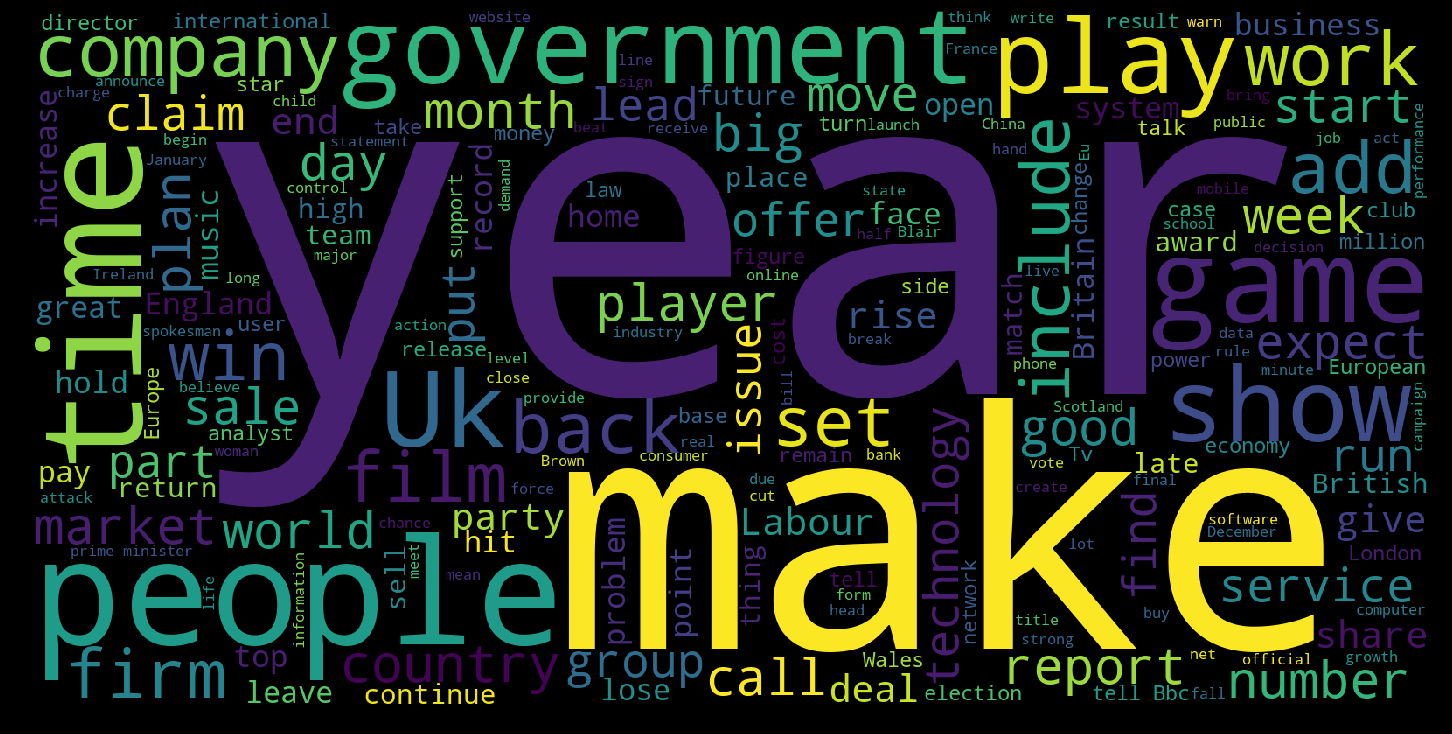

In [18]:
#saves wordcloud of all tokens as file. Please note, this word cloud is for all tokens not just noun tokens
wordcloudplot(all_tokens, 'img_wordcloud.png')

Comments on this...

## Step 4 : Most Common Bigrams and Trigrams

### Bigrams

In [23]:
print("Top five Bigrams, frequencies: ")
most_common_words = [word for word, word_count in Counter(ngrams(all_tokens,2)).most_common(5)]
print (most_common_words)

Top five Bigrams, frequencies: 
[('tell', 'Bbc'), ('prime', 'minister'), ('Tony', 'Blair'), ('year', 'ago'), ('chief', 'executive')]


In [24]:
n=2
bigram = ngrams(all_tokens,n)
bi_frequencies = nltk.FreqDist(bigram)
dict_items =list(dict(bi_frequencies).items())
#make a dataframe of the bigrams and their frequencies
df_bigramFreq = pd.DataFrame(dict_items,columns=['bigram','freq']).sort_values(by='freq', ascending=False)
df_bigramFreq = df_bigramFreq.reset_index(drop=True)
#show only top five
df_bigramFreq.head(5)

,bigram,freq
0,"(tell, Bbc)",246
1,"(prime, minister)",170
2,"(Tony, Blair)",127
3,"(year, ago)",127
4,"(chief, executive)",122


In [25]:
# Function to check the gram is noun gram or not
def IsNounGram(ngram):
    if ('-pron-' in ngram) or ('t' in ngram):
        return False
    
    first_type = ('JJ','JJR','JJS','NN','NNS','NNP','NNPS')
    second_type = ('NN','NNS','NNP','NNPS')
    tags = nltk.pos_tag(ngram,lang='eng')
    if (tags[0][1] in first_type) and (tags[1][1] in second_type):
        return True
    else:
        return False

In [26]:
#only show noun grams
df_bigramFreq_filter = df_bigramFreq[df_bigramFreq.bigram.map(lambda x : IsNounGram(x))]
df_bigramFreq_filter = df_bigramFreq_filter.reset_index(drop=True)
df_bigramFreq_filter.head(5)

,bigram,freq
0,"(tell, Bbc)",246
1,"(prime, minister)",170
2,"(Tony, Blair)",127
3,"(chief, executive)",122
4,"(Bbc, News)",120


Comments on this...

In [27]:
def CheckWordInText(word, Text):
    if word in Text.lower():
        return True
    else:
        return False

In [29]:
#combine all texts
full_corpus = ''
# combine all the tokens
for index, row in df_handle.iterrows():
    full_corpus = full_corpus + df_handle['content'].iloc[index]

In [ ]:
df_real_bigram = df_bigramFreq_filter.copy()

exits_list = []
for index, row in df_bigramFreq_filter.iterrows():
    gram = row['bigram']
    word = (' '.join(gram))
    exits_list.append(CheckWordInText(word, full_corpus))
    
df_real_bigram['exist'] = exits_list
df_real_bigram = df_real_bigram.loc[df_real_bigram.exist==True]
df_real_bigram = df_real_bigram.reset_index(drop=True)

df_real_bigram.head(5)

Comments on this...

### Trigrams

In [1]:
n = 3
trigram = ngrams(all_tokens,n)
tri_frequencies = nltk.FreqDist(trigram)
dict_items =list(dict(tri_frequencies).items())
#make a dataframe of the trigrams and their frequencies
df_trigramFreq = pd.DataFrame(dict_items,columns=['trigram','freq']).sort_values(by='freq', ascending=False)
df_trigramFreq = df_trigramFreq.reset_index(drop=True)

#check for noun grams
df_trigramFreq_filter = df_trigramFreq[df_trigramFreq.trigram.map(lambda x : IsNounGram(x))]
df_trigramFreq_filter = df_trigramFreq_filter.reset_index(drop=True)
#print (df_trigramFreq.head(5) == df_trigramFreq_filter.head(5))

#check in text
df_real_trigram = df_trigramFreq_filter.copy()

exits_list = []
for index, row in df_trigramFreq_filter.iterrows():
    gram = row['trigram']
    word = (' '.join(gram))
    exits_list.append(CheckWordInText(word, full_corpus))
    
df_real_trigram['exist'] = exits_list
df_real_trigram = df_real_trigram.loc[df_real_trigram.exist==True]
df_real_trigram = df_real_trigram.reset_index(drop=True)

#df_trigramFreq_filter.head(5)
df_real_trigram.head(5)

NameError: name 'ngrams' is not defined

In [6]:
# TODO: the column used for "tokens" needs to be updated to use clean noun tokens. 
# change the next line once this is done: df_handle["noun_tokens"]
merged_tokens = [" ".join(x) for x in df_handle["Tokens"]]
tfidf_vectorizer = TfidfVectorizer(norm=None)
tfidf_out = pd.DataFrame(tfidf_vectorizer.fit_transform(merged_tokens).todense(), columns = tfidf_vectorizer.get_feature_names())
tfidf_out

NameError: name 'TfidfVectorizer' is not defined